In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gc

# --- Physical Parameters ---
mass = 1.0
hbar = (1/5)**0.5
V0 = 3.0
xi = 10.0
I_0 = 10.0

# Energy range
n_energies = 20
energy_min, energy_max = 2.0, 2.1

# --- Channel Parameters ---
j_max = 5
j_vals = np.arange(-j_max, j_max + 1)
n_ch = len(j_vals)

# --- Simulation Box ---
L = 80.0 # Total width of the simulation box (-L/2 to L/2)

# --- Non-Uniform Grid Definition ---
print("--- Building Non-Uniform Grid ---")
N_fine_per_spike = 400
width_fine_region = 6.0
N_coarse_inner_region = 50
N_coarse_outer_region = 75

spike_centers = [-10.0, 0.0, 10.0]
sim_boundary = L / 2

x1 = np.linspace(-sim_boundary, spike_centers[0] - width_fine_region/2, N_coarse_outer_region, endpoint=False)
x2 = np.linspace(spike_centers[0] - width_fine_region/2, spike_centers[0] + width_fine_region/2, N_fine_per_spike, endpoint=False)
x3 = np.linspace(spike_centers[0] + width_fine_region/2, spike_centers[1] - width_fine_region/2, N_coarse_inner_region, endpoint=False)
x4 = np.linspace(spike_centers[1] - width_fine_region/2, spike_centers[1] + width_fine_region/2, N_fine_per_spike, endpoint=False)
x5 = np.linspace(spike_centers[1] + width_fine_region/2, spike_centers[2] - width_fine_region/2, N_coarse_inner_region, endpoint=False)
x6 = np.linspace(spike_centers[2] - width_fine_region/2, spike_centers[2] + width_fine_region/2, N_fine_per_spike, endpoint=False)
x7 = np.linspace(spike_centers[2] + width_fine_region/2, sim_boundary, N_coarse_outer_region)

x = np.concatenate([x1, x2, x3, x4, x5, x6, x7])
N = len(x)

# The crucial vector of local grid spacings for the integral
dx_vec = np.gradient(x)

print(f"Total points in grid (N): {N}")

--- Building Non-Uniform Grid ---
Total points in grid (N): 1450


In [2]:
def potential_triplet(x_p, V0_val=V0, xi_val=xi):
    m_vals = np.array([-1, 0, 1])
    # This function is called for a single xm at a time in the modified build_K_matrix
    return V0_val * (np.sum([np.exp(-(x_p - m * xi_val)**2) for m in m_vals]))

def greens_function(xn, xm, kj):
    return -(1j * mass) / (hbar**2 * kj) * np.exp(1j * kj * np.abs(xn - xm))

def calculate_k_values_for_energy(E_val, j_vals, mass, hbar, I_0):
    k_vals_new = np.zeros(len(j_vals), dtype=complex)
    # Add a small imaginary part to E to regularize the Green's function
    E_complex = E_val + 1j*1e-8
    for idx, j in enumerate(j_vals):
        val = 2 * mass * (E_complex - ((j ** 2) * (hbar**2) / (2 * I_0)))
        # Take the principal square root which correctly handles signs
        k_vals_new[idx] = np.sqrt(val)
    return k_vals_new

def construct_full_s_matrix(all_f_coeffs, k_vals, j_vals):
    # This function is unchanged as it does not depend on the spatial grid
    open_channel_indices = [i for i in range(len(j_vals)) if np.imag(k_vals[i]) < 1e-6]
    n_open_channels = len(open_channel_indices)
    
    S_matrix = np.zeros((2*n_open_channels, 2*n_open_channels), dtype=np.complex128)
    
    for i, inc_channel in enumerate(open_channel_indices):
        if inc_channel in all_f_coeffs:
            f_coeffs = all_f_coeffs[inc_channel]
            for j, out_channel in enumerate(open_channel_indices):
                r_coeff = f_coeffs[out_channel, 0]
                T_coeff = f_coeffs[out_channel, 1]
                
                # Standard S-matrix block structure
                S_matrix[j, i] = T_coeff
                S_matrix[j, i + n_open_channels] = r_coeff
                S_matrix[j + n_open_channels, i] = r_coeff
                S_matrix[j + n_open_channels, i + n_open_channels] = T_coeff
    return S_matrix

In [3]:
def build_K_matrix(k_vals, j_vals, x, dx_vec, n_ch):
    N = len(x)
    dim = n_ch * N
    K = np.zeros((dim, dim), dtype=np.complex128)

    # Optimization to only loop over regions with significant potential
    window_half_width = 3.0
    potential_mask = (np.abs(x - (-xi)) < window_half_width) | \
                     (np.abs(x - 0)   < window_half_width) | \
                     (np.abs(x - (xi))  < window_half_width)
    active_xm_indices = np.where(potential_mask)[0]
    # Pre-calculate the potential values ONLY at the active sites
    V_vals_active = np.array([potential_triplet(xm) for xm in x[active_xm_indices]])

    for j_idx, j in enumerate(j_vals):
        kj = k_vals[j_idx]
        for xn_idx, xn in enumerate(x):
            row_idx = j_idx * N + xn_idx

            # Coupling to j-1
            l = j - 1
            if l in j_vals:
                l_idx = np.where(j_vals == l)[0][0]
                for i,xm_idx in enumerate(active_xm_indices):
                    xm = x[xm_idx]
                    col_idx = l_idx * N + xm_idx
                    G_val = greens_function(xn, xm, kj)
                    K[row_idx, col_idx] += G_val * V_vals_active[i] * dx_vec[xm_idx] 

            # Coupling to j+1
            l = j + 1
            if l in j_vals:
                l_idx = np.where(j_vals == l)[0][0]
                for i,xm_idx in enumerate(active_xm_indices):
                    xm = x[xm_idx]
                    col_idx = l_idx * N + xm_idx
                    G_val = greens_function(xn, xm, kj)
                    K[row_idx, col_idx] += G_val * V_vals_active[i] * dx_vec[xm_idx] 
    print(K.shape)
    print(K[np.nonzero(K)])
    return K

In [4]:
def calculate_scattering_for_incident_channel(inc_channel_idx, K, k_vals, j_vals, x, n_ch, L_box):
    N = len(x)
    dim = N * n_ch
    
    phi = np.zeros(dim, dtype=np.complex128)
    for xn_idx, xn_val in enumerate(x):
        idx = inc_channel_idx * N + xn_idx
        phi[idx] = np.exp(1j * k_vals[inc_channel_idx] * xn_val)
    
    A = np.eye(dim, dtype=np.complex128) - K
    psi = np.linalg.solve(A, phi)
    psi_mat = psi.reshape((n_ch, N))
    
    # Your original mask definitions
    refl_mask = x < -L_box/4
    trans_mask = x > L_box/4
    
    r_coeffs = np.zeros(n_ch, dtype=np.complex128)
    t_coeffs = np.zeros(n_ch, dtype=np.complex128)

    open_channel_mask = np.abs(np.imag(k_vals)) < 1e-6

    for idx_ch, kj in enumerate(k_vals):
        if open_channel_mask[idx_ch]:
            # Reflection
            x_refl = x[refl_mask]
            M_refl = np.vstack([np.exp(1j*kj*x_refl), np.exp(-1j*kj*x_refl)]).T
            coeffs_refl, _, _, _ = np.linalg.lstsq(M_refl, psi_mat[idx_ch, refl_mask], rcond=None)
            r_coeffs[idx_ch] = coeffs_refl[1]
            
            # Transmission
            x_trans = x[trans_mask]
            M_trans = np.vstack([np.exp(1j*kj*x_trans), np.exp(-1j*kj*x_trans)]).T
            coeffs_trans, _, _, _ = np.linalg.lstsq(M_trans, psi_mat[idx_ch, trans_mask], rcond=None)
            t_val = coeffs_trans[0]

            t_coeffs[idx_ch] = t_val

    f_coeffs = np.zeros((n_ch, 2), dtype=np.complex128)
    f_coeffs[:, 0] = r_coeffs
    f_coeffs[:, 1] = t_coeffs

    del K
    del A
    # Manually trigger garbage collection
    gc.collect()
    
    return f_coeffs

In [5]:
def single_energy_s_matrix(E_val, j_vals, x, dx_vec, n_ch, mass, hbar, I_0, L_box):
    N = len(x)
    k_vals_E = calculate_k_values_for_energy(E_val, j_vals, mass, hbar, I_0)
    
    print(f"Building K matrix for E = {E_val:.3f}")
    K = build_K_matrix(k_vals_E, j_vals, x, dx_vec, n_ch)
    
    open_channel_indices = [i for i in range(len(j_vals)) if np.imag(k_vals_E[i]) < 1e-6]
    
    incident_channels = []
    inc_channel_range = range(-j_max, j_max + 1)
    for j_inc in inc_channel_range:
        if j_inc in j_vals:
            idx = np.where(j_vals == j_inc)[0][0]
            if idx in open_channel_indices:
                incident_channels.append(idx)

    print(f"  Open incident channels: {[j_vals[i] for i in incident_channels]}")
    
    all_f_coeffs_E = {}
    for inc_idx in incident_channels:
        j_inc = j_vals[inc_idx]
        print(f"  Processing incident channel j = {j_inc}")
        f_coeffs = calculate_scattering_for_incident_channel(inc_idx, K, k_vals_E, j_vals, x, n_ch, L_box)
        all_f_coeffs_E[inc_idx] = f_coeffs
        # Quick verification
        total_prob = np.sum(np.abs(f_coeffs[:, 0])**2 + np.abs(f_coeffs[:, 1])**2)
        print(f"    Total probability: {total_prob:.6f}")
    
    S_matrix_E = construct_full_s_matrix(all_f_coeffs_E, k_vals_E, j_vals)
    
    del K
    gc.collect()
    
    return S_matrix_E, k_vals_E

In [6]:
def calculate_level_statistics(energy_range, j_vals, x, dx_vec, n_ch, mass, hbar, I_0, L_box):
    all_eigenphases = []
    all_S_matrices = []
    valid_energies = []
    
    N = len(x) # N is now derived from the grid
    
    print(f"Calculating level statistics for {len(energy_range)} energy points...")
    
    for i, E_val in enumerate(energy_range):
        print(f"\n--- Processing energy {i+1}/{len(energy_range)}: E = {E_val:.3f} ---")
        try:
            S_matrix_E, k_vals_E = single_energy_s_matrix(E_val, j_vals, x, dx_vec, n_ch, mass, hbar, I_0, L_box)
            
            if S_matrix_E.shape[0] < 2:
                print(f"  Skipping E={E_val:.3f}: S-matrix too small or not formed.")
                continue
            
            eigenvalues = np.linalg.eigvals(S_matrix_E)
            phases = np.angle(eigenvalues)
            
            phases = phases[np.isfinite(phases)]
            
            if len(phases) > 2:
                all_eigenphases.append(phases)
                all_S_matrices.append(S_matrix_E)
                valid_energies.append(E_val)
                print(f"  Successfully processed: {len(phases)} eigenphases")
            else:
                print(f"  Skipping E={E_val:.3f}: insufficient valid phases")
        except Exception as e:
            print(f"  An error occurred at E={E_val:.3f}: {e}")
            gc.collect()
            continue
            
    return all_eigenphases, all_S_matrices, valid_energies

In [7]:
# --- Main Execution ---
# Define the energy range for the final analysis
# energy_min, energy_max = 1.5, 2.3
# n_energies = 1 

energy_range = np.linspace(energy_min, energy_max, n_energies)

# Run the entire calculation
all_phases, all_S_mats, valid_energies = calculate_level_statistics(
    energy_range, j_vals, x, dx_vec, n_ch, mass, hbar, I_0, L
)

print(f"\n--- Summary ---")
print(f"Total energies attempted: {len(energy_range)}")
print(f"Successfully processed: {len(valid_energies)}")

Calculating level statistics for 20 energy points...

--- Processing energy 1/20: E = 2.000 ---
Building K matrix for E = 2.000
(15950, 15950)
[4.40820766e-06-1.56264174e-05j 5.29762043e-06-1.69445136e-05j
 6.30735426e-06-1.83496532e-05j ... 6.30735426e-06-1.83496532e-05j
 5.29762043e-06-1.69445136e-05j 4.40820766e-06-1.56264174e-05j]
  Open incident channels: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
  Processing incident channel j = -5
    Total probability: 0.966614
  Processing incident channel j = -4
    Total probability: 0.990482
  Processing incident channel j = -3
    Total probability: 1.010496
  Processing incident channel j = -2
    Total probability: 1.008550
  Processing incident channel j = -1
    Total probability: 1.015843
  Processing incident channel j = 0
    Total probability: 1.020708
  Processing incident channel j = 1
    Total probability: 1.015843
  Processing incident channel j = 2
    Total probability: 1.008550
  Processing incident channel j = 3
    Total pro

In [8]:
def analyze_level_spacings(all_eigenphases):
    """Analyze level spacing statistics"""
    all_spacings = []
    all_ratios = []
    
    print("Analyzing level spacings...")
    
    for i, phases in enumerate(all_eigenphases):
        # Sort phases and calculate spacings
        sorted_phases = np.sort(phases)
        spacings = np.diff(sorted_phases)
        
        # Remove very small spacings (numerical artifacts)
        spacings = spacings[spacings > 1e-6]
        
        if len(spacings) > 1:
            # Normalize by mean spacing
            mean_spacing = np.mean(spacings)
            if mean_spacing > 1e-10:
                normalized_spacings = spacings / mean_spacing
                all_spacings.extend(normalized_spacings)
                
                # Calculate ratios for neighboring spacings
                for j in range(len(spacings)-1):
                    s1, s2 = spacings[j], spacings[j+1]
                    ratio = min(s1, s2) / max(s1, s2)
                    all_ratios.append(ratio)
                
                print(f"  Energy {i+1}: {len(spacings)} spacings, mean = {mean_spacing:.4f}")
    
    return np.array(all_spacings), np.array(all_ratios)

def classify_chaos(mean_ratio):
    """Classify the system based on level spacing ratio"""
    # Theoretical values:
    # Poisson (regular): ~0.386
    # GOE (chaotic): ~0.536
    # GUE (chaotic with time-reversal broken): ~0.603
    
    if mean_ratio > 0.53:
        return "Chaotic (GOE-like)"
    elif mean_ratio < 0.39:
        return "Regular (Poisson-like)"
    else:
        return "Intermediate"

# Analyze spacings if we have data
if len(all_phases) > 0:
    spacings, ratios = analyze_level_spacings(all_phases)
    
    if len(spacings) > 5 and len(ratios) > 5:
        # Calculate statistics
        mean_spacing = np.mean(spacings)
        std_spacing = np.std(spacings)
        mean_ratio = np.mean(ratios)
        std_ratio = np.std(ratios)
        
        print(f"\n{'='*50}")
        print(f"LEVEL SPACING STATISTICS")
        print(f"{'='*50}")
        print(f"Number of spacings analyzed: {len(spacings)}")
        print(f"Number of ratios analyzed: {len(ratios)}")
        print(f"Mean normalized spacing: {mean_spacing:.4f} ± {std_spacing:.4f}")
        print(f"Mean spacing ratio: {mean_ratio:.4f} ± {std_ratio:.4f}")
        
        # Classification
        chaos_classification = classify_chaos(mean_ratio)
        print(f"System classification: {chaos_classification}")
        
        # Additional chaos indicators
        print(f"\nChaos Indicators:")
        print(f"- Ratio < 0.39: Regular/Integrable")
        print(f"- Ratio ≈ 0.536: Chaotic (GOE)")
        print(f"- Ratio > 0.53: Chaotic")
        print(f"- Current ratio: {mean_ratio:.4f}")
        
    else:
        print("Insufficient data for meaningful level spacing analysis")
        print(f"Got {len(spacings)} spacings and {len(ratios)} ratios")
        print("Need at least 5 of each for reliable statistics")
else:
    print("No eigenphases calculated - check energy range and parameters")


Analyzing level spacings...
  Energy 1: 21 spacings, mean = 0.2559
  Energy 2: 21 spacings, mean = 0.2569
  Energy 3: 21 spacings, mean = 0.2587
  Energy 4: 21 spacings, mean = 0.2869
  Energy 5: 21 spacings, mean = 0.2639
  Energy 6: 21 spacings, mean = 0.2637
  Energy 7: 21 spacings, mean = 0.2702
  Energy 8: 21 spacings, mean = 0.2671
  Energy 9: 21 spacings, mean = 0.2688
  Energy 10: 21 spacings, mean = 0.2705
  Energy 11: 21 spacings, mean = 0.2721
  Energy 12: 21 spacings, mean = 0.2738
  Energy 13: 21 spacings, mean = 0.2754
  Energy 14: 21 spacings, mean = 0.2770
  Energy 15: 21 spacings, mean = 0.2786
  Energy 16: 21 spacings, mean = 0.2802
  Energy 17: 21 spacings, mean = 0.2818
  Energy 18: 21 spacings, mean = 0.2661
  Energy 19: 21 spacings, mean = 0.2663
  Energy 20: 21 spacings, mean = 0.2668

LEVEL SPACING STATISTICS
Number of spacings analyzed: 420
Number of ratios analyzed: 400
Mean normalized spacing: 1.0000 ± 0.7916
Mean spacing ratio: 0.3759 ± 0.2808
System classif

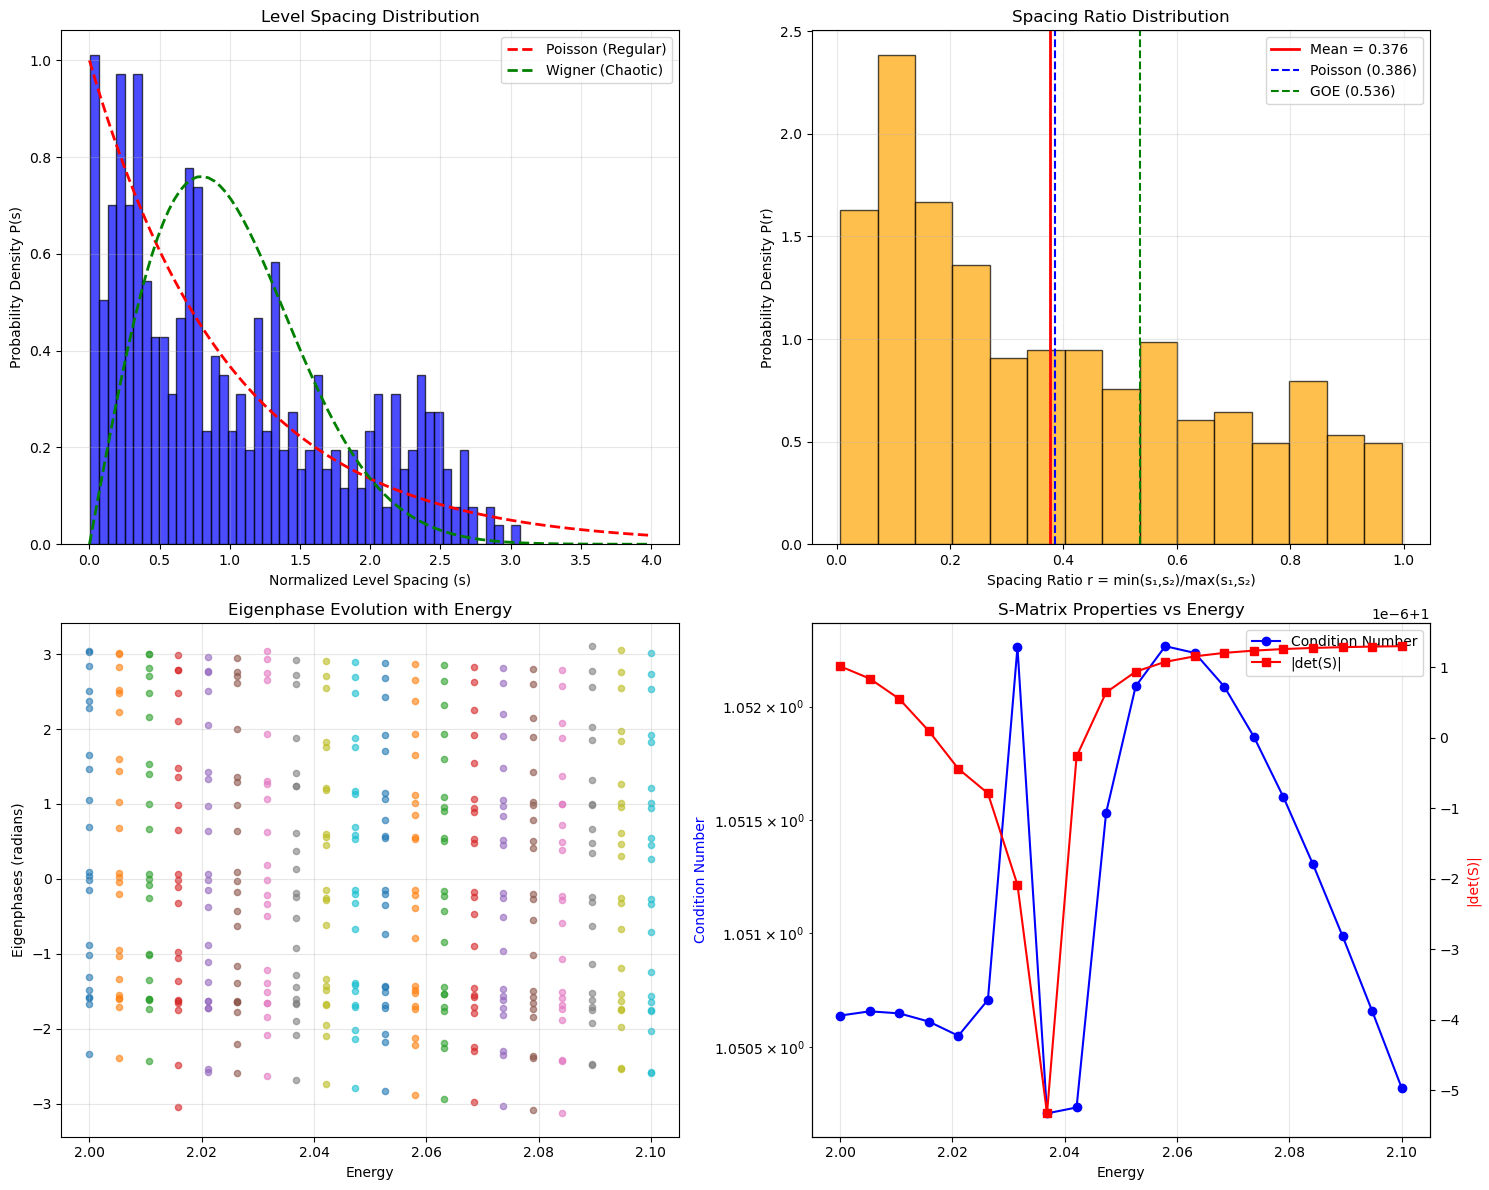


CHAOS ANALYSIS SUMMARY
Energy range: 2.00 - 2.10
Number of energies analyzed: 20
Total eigenphases: 440
Mean spacing ratio: 0.3759 ± 0.2808
System classification: Regular (Poisson-like)
Unitarity check: All S-matrices should be unitary


In [9]:
import matplotlib.pyplot as plt

# Visualization of results
if len(all_phases) > 0 and len(spacings) > 5:
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Level spacing histogram
    ax1.hist(spacings, bins=min(50, len(spacings)//3), alpha=0.7, density=True, 
             color='blue', edgecolor='black')
    ax1.set_xlabel('Normalized Level Spacing (s)')
    ax1.set_ylabel('Probability Density P(s)')
    ax1.set_title('Level Spacing Distribution')
    ax1.grid(True, alpha=0.3)
    
    # Add theoretical curves if enough data
    if len(spacings) > 20:
        s_theory = np.linspace(0, 4, 100)
        # Poisson: P(s) = exp(-s)
        poisson = np.exp(-s_theory)
        # Wigner-Dyson (GOE): P(s) = (π/2)s exp(-πs²/4)
        wigner = (np.pi/2) * s_theory * np.exp(-np.pi * s_theory**2 / 4)
        
        ax1.plot(s_theory, poisson, 'r--', label='Poisson (Regular)', linewidth=2)
        ax1.plot(s_theory, wigner, 'g--', label='Wigner (Chaotic)', linewidth=2)
        ax1.legend()
    
    # Plot 2: Ratio histogram
    if len(ratios) > 5:
        ax2.hist(ratios, bins=min(15, len(ratios)//3), alpha=0.7, density=True, 
                 color='orange', edgecolor='black')
        ax2.axvline(x=mean_ratio, color='red', linestyle='-', linewidth=2, 
                   label=f'Mean = {mean_ratio:.3f}')
        ax2.axvline(x=0.386, color='blue', linestyle='--', label='Poisson (0.386)')
        ax2.axvline(x=0.536, color='green', linestyle='--', label='GOE (0.536)')
        ax2.set_xlabel('Spacing Ratio r = min(s₁,s₂)/max(s₁,s₂)')
        ax2.set_ylabel('Probability Density P(r)')
        ax2.set_title('Spacing Ratio Distribution')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # Plot 3: Eigenphases vs Energy
    if len(valid_energies) > 1:
        for i, (E, phases) in enumerate(zip(valid_energies, all_phases)):
            ax3.scatter([E]*len(phases), phases, alpha=0.6, s=20)
        ax3.set_xlabel('Energy')
        ax3.set_ylabel('Eigenphases (radians)')
        ax3.set_title('Eigenphase Evolution with Energy')
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: S-matrix properties vs Energy
    if len(all_S_mats) > 1:
        condition_numbers = []
        determinants = []
        
        for S_mat in all_S_mats:
            condition_numbers.append(np.linalg.cond(S_mat))
            determinants.append(np.abs(np.linalg.det(S_mat)))
        
        ax4_twin = ax4.twinx()
        line1 = ax4.semilogy(valid_energies, condition_numbers, 'b-o', label='Condition Number')
        line2 = ax4_twin.plot(valid_energies, determinants, 'r-s', label='|det(S)|')
        
        ax4.set_xlabel('Energy')
        ax4.set_ylabel('Condition Number', color='b')
        ax4_twin.set_ylabel('|det(S)|', color='r')
        ax4.set_title('S-Matrix Properties vs Energy')
        ax4.grid(True, alpha=0.3)
        
        # Combine legends
        lines1, labels1 = ax4.get_legend_handles_labels()
        lines2, labels2 = ax4_twin.get_legend_handles_labels()
        ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print(f"\n{'='*60}")
    print(f"CHAOS ANALYSIS SUMMARY")
    print(f"{'='*60}")
    print(f"Energy range: {energy_min:.2f} - {energy_max:.2f}")
    print(f"Number of energies analyzed: {len(valid_energies)}")
    print(f"Total eigenphases: {sum(len(phases) for phases in all_phases)}")
    print(f"Mean spacing ratio: {mean_ratio:.4f} ± {std_ratio:.4f}")
    print(f"System classification: {chaos_classification}")
    print(f"Unitarity check: All S-matrices should be unitary")
    
else:
    print("Insufficient data for visualization")
    print(f"Number of energy points with data: {len(all_phases)}")
    print(f"Number of spacings: {len(spacings) if 'spacings' in locals() else 0}")
